# Import Libraries
This cell imports all necessary libraries for the implementation and visualization.


In [4]:
# Import necessary libraries
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
import warnings
warnings.filterwarnings("ignore")


# Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler
## 1.A – Metropolis-Hastings within Gibbs sampler

We aim to sample the target distribution $\pi$ on $\mathbb{R}^2$ given by:

$$
\pi(x, y) \propto \exp\left(-\frac{x^2}{a^2} - y^2 - \frac{1}{4} \left(\frac{x^2}{a^2} - y^2 \right)^2 \right)
$$

where $a > 0$.

We consider a Markov transition kernel $P$ defined by:

$$
P = \frac{1}{2} (P_1 + P_2)
$$

where $P_i((x, y); dx' \times dy')$ for $i = 1, 2$ is the Markov transition kernel that updates only the $i$-th component. This update follows a symmetric random walk proposal mechanism and uses a Gaussian distribution with variance $\sigma_i^2$.

### Question 1:
1. Implement an algorithm that samples the distribution $P_1(z; \cdot)$, where $z \in \mathbb{R}^2$, and likewise for $P_2(z; \cdot)$.
2. Implement an algorithm that samples a chain with kernel $P$.


In [5]:
# Target distribution
def log_pi(x, y, a):
    return -(x / a) ** 2 - y ** 2 - (1 / 4) * (((x / a) ** 2 - y ** 2) ** 2)

# Sample the distribution P1
def sample_P1(x0, y0, sigma, a):
    x_ = np.random.normal(x0, sigma[0], size=1)[0]
    log_a = log_pi(x_, y0, a) - log_pi(x0, y0, a)
    log_a = np.min([0, log_a])
    log_u = np.log(np.random.rand())

    if log_u <= log_a:
        return x_, y0, np.exp(log_a), True
    else:
        return x0, y0, np.exp(log_a), False

# Sample the distribution P2
def sample_P2(x0, y0, sigma, a):
    y_ = np.random.normal(y0, sigma[1], size=1)[0]
    log_a = log_pi(x0, y_, a) - log_pi(x0, y0, a)
    log_a = np.min([0, log_a])
    log_u = np.log(np.random.rand())

    if log_u <= log_a:
        return x0, y_, np.exp(log_a), True
    else:
        return x0, y0, np.exp(log_a), False

# Sample a chain with kernel P
def sample_P(x0, y0, p, sigma, a, N):
    sam = np.zeros((N, 2))  # Samples
    sam[0, :] = [x0, y0]    # Initial value
    acc_rate_x = acc_rate_y = 0
    acc_x, acc_y = [], []

    for i in range(1, N):
        u = np.random.uniform()
        if u <= p:
            x, y, val, b = sample_P1(sam[i - 1, 0], sam[i - 1, 1], sigma, a)
            sam[i, :] = [x, y]
            if b:
                acc_rate_x += 1
        else:
            x, y, val, b = sample_P2(sam[i - 1, 0], sam[i - 1, 1], sigma, a)
            sam[i, :] = [x, y]
            if b:
                acc_rate_y += 1

        if i % 50 == 0:
            acc_x.append(acc_rate_x / 50)
            acc_y.append(acc_rate_y / 50)
            acc_rate_x = acc_rate_y = 0

    return sam, acc_x, acc_y


### Question 2:
Run the algorithm with $a = 10$ and standard deviations of the proposal distributions chosen as follows: $(\sigma_1, \sigma_2) = (3, 3)$. Discuss the performance of the algorithm.
#### 1. Sampling Results


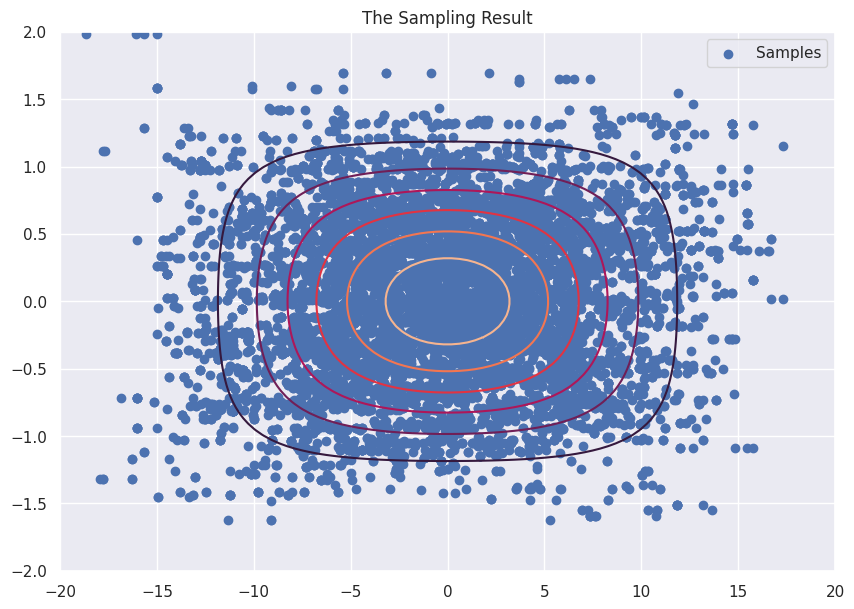

In [37]:
# Testing the algorithm
sam, acc_x, acc_y = sample_P(1, 1, 0.5, [3, 3], 10, 10000)

# Computing the target distribution
x = np.linspace(-20, 20, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = np.exp(log_pi(X, Y, 10)).reshape(X.shape)

# Plots
plt.figure(figsize=(10, 7))
plt.contour(X, Y, Z)
plt.scatter(sam[:, 0], sam[:, 1], label='Samples')
plt.title('The Sampling Result')
plt.legend()
plt.show()


#### 2. Acceptance Rate


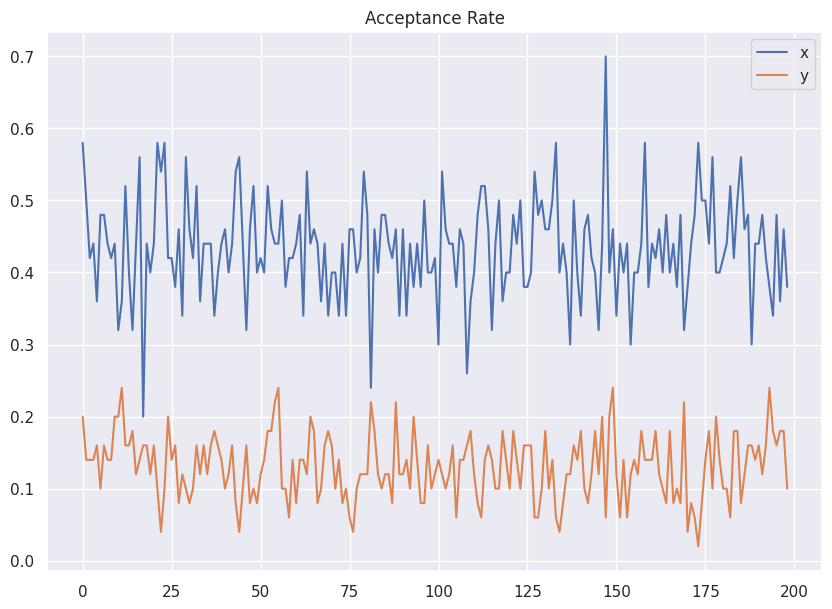

In [7]:
 plt.figure(figsize=(10, 7))
plt.plot(acc_x, label='x')
plt.plot(acc_y, label='y')
plt.legend()
plt.title('Acceptance Rate')
plt.show()


#### 3. Autocorrelation Plots


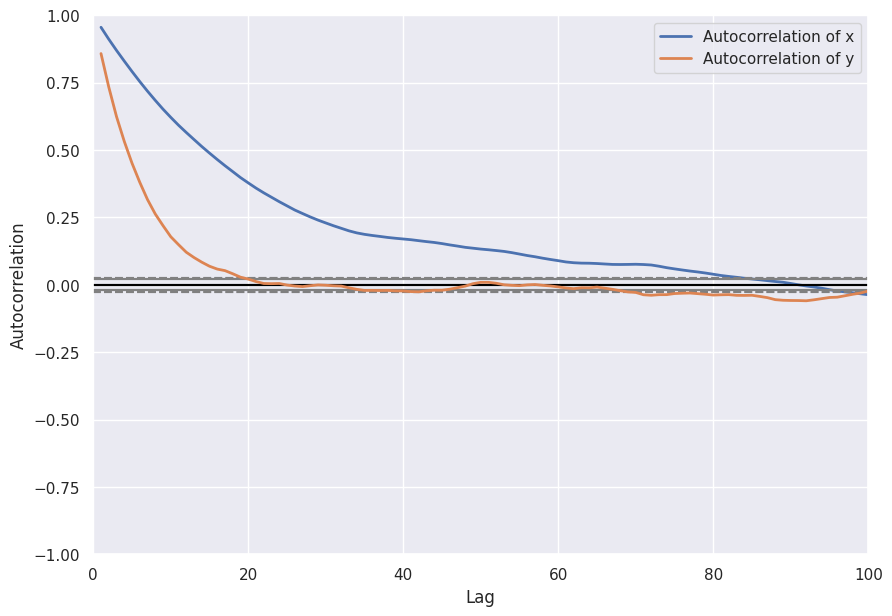

In [8]:
plt.figure(figsize=(10, 7))
pd.plotting.autocorrelation_plot(sam[:, 0], label='Autocorrelation of x', linewidth=2)
pd.plotting.autocorrelation_plot(sam[:, 1], label='Autocorrelation of y', linewidth=2)
plt.xlim((0, 100))
plt.show()


#### 4. Interpretation
From the previous sampling results, the sampling is poor with this method. Many points are sampled outside the target distribution, especially along the $x$-axis. The acceptance rates deviate significantly from the ideal value (around 0.24). Additionally, the autocorrelation of the $x$-coordinate indicates non-convergence, implying strong correlation between consecutive samples.

Intuitevely, we can say this is due to the symmetry between $\frac{x}{a}$ and $y$ and not $x$ an $y$, so we can't have propose a similar standard deviation for the $x$ and $y$.

## Question 3:
How could the performance of the above algorithm be improved? Propose two methods.

### Proposed Methods:
1. **Increase the probability of sampling the x-coordinate**: By decreasing the probability of sampling along the x-axis (e.g., from 0.5 to 0.234), we can focus more on the poorly performing dimension.
2. **Adjust the variances of the proposal distributions**: By increasing the variance along the x-axis and decreasing it along the y-axis (e.g., $\sigma_1 = 30$, $\sigma_2 = 3$), we encourage greater exploration along the x-dimension and we try to take adavantge of that symmetry between $\frac{x}{10}$ and $y$.

### Method 1: Increase the probability of sampling the x-coordinate
#### 1. Sampling Results


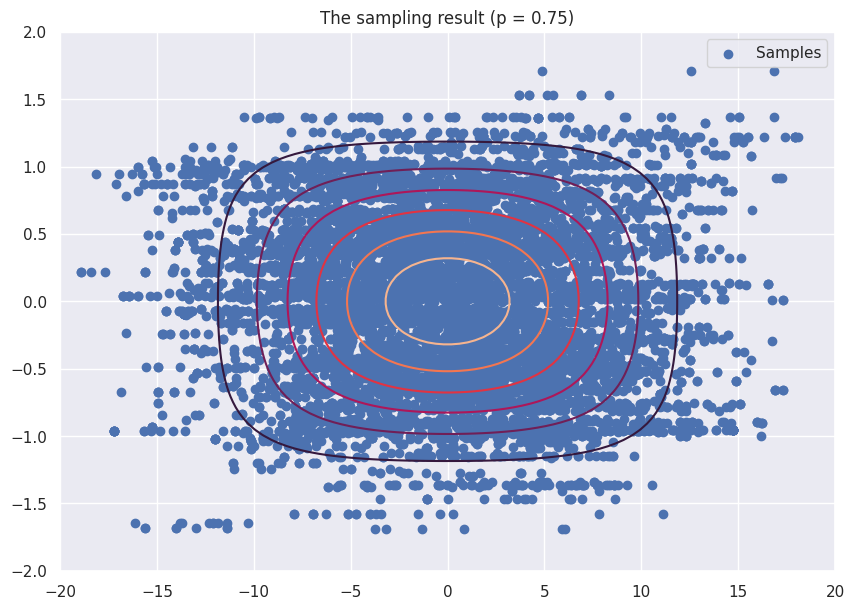

In [49]:
# Change probability from 0.5 to 0.75
sam, acc_x, acc_y = sample_P(1, 1, 0.75, [3, 3], 10, 10000)

# Plots
plt.figure(figsize=(10, 7))
plt.contour(X, Y, Z)
plt.scatter(sam[:, 0], sam[:, 1], label='Samples')
plt.title('The sampling result (p = 0.75)')
plt.legend()
plt.show()


#### 2. Acceptance Rate


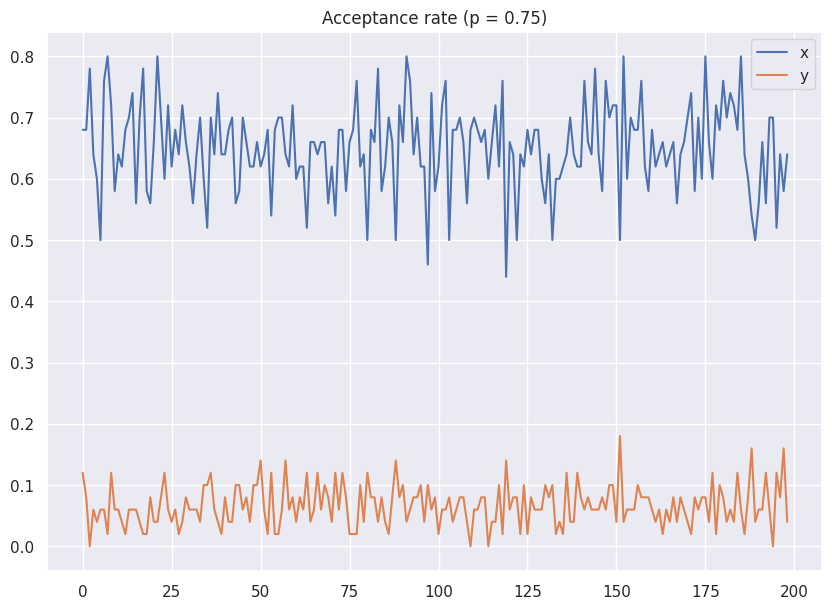

In [50]:
plt.figure(figsize=(10, 7))
plt.plot(acc_x, label='x')
plt.plot(acc_y, label='y')
plt.legend()
plt.title('Acceptance rate (p = 0.75)')
plt.show()


#### 3. Autocorrelation Plots


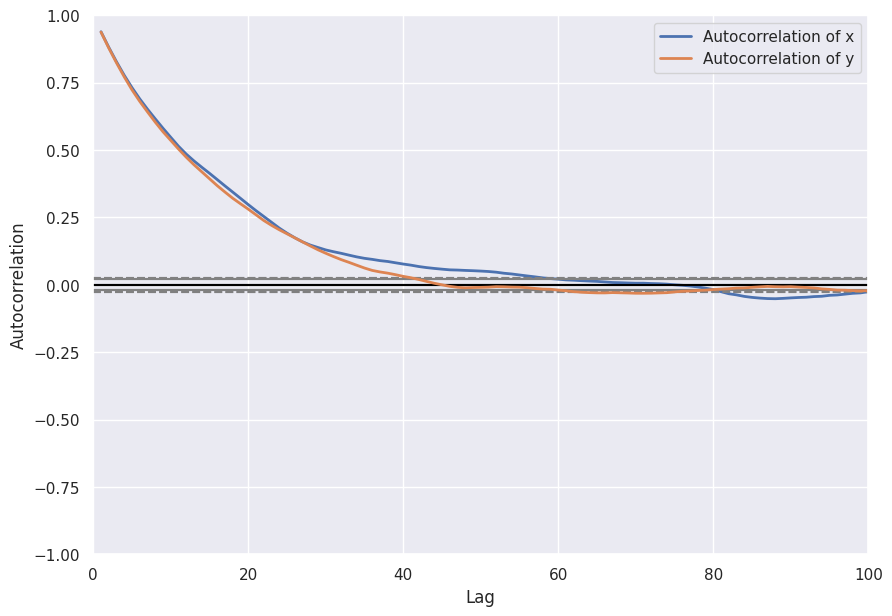

In [51]:
# Creating Autocorrelation plots
plt.figure(figsize=(10, 7))
pd.plotting.autocorrelation_plot(sam[:, 0], label='Autocorrelation of x', linewidth=2)
pd.plotting.autocorrelation_plot(sam[:, 1], label='Autocorrelation of y', linewidth=2)
# Limit the lags in the plot
plt.xlim((0, 100))
plt.show()


#### 4. Interpretation
With this method, the sampling aligns more closely with the target distribution. The x-coordinate exhibits better sampling, and the autocorrelation plots of both x and y-coordinates are closer to each other. However, the acceptance rate of the x-coordinate increases significantly, which indicates that more samples are being accepted along the x-axis. Overall, this method improves the results compared to the original approach.


### Method 2: Adjust Variances of Proposal Distributions
#### 1. Sampling Results
By setting $\sigma_1 = 30$ and $\sigma_2 = 3$, we allow for greater variability along the x-dimension while maintaining tighter control along the y-dimension.


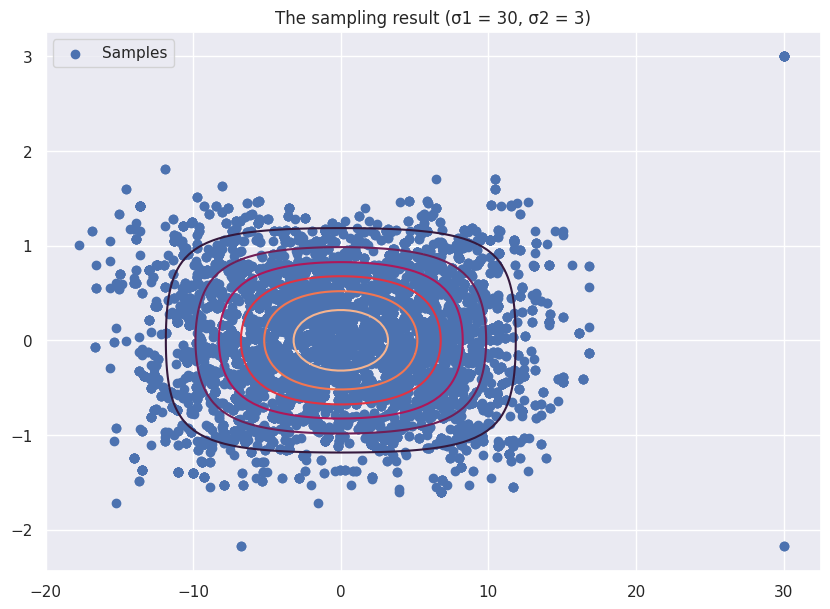

In [41]:
# Adjust variances: sigma1 = 30, sigma2 = 3
sam, acc_x, acc_y = sample_P(30, 3, 0.5, [30, 3], 10, 10000)

# Plots
plt.figure(figsize=(10, 7))
plt.contour(X, Y, Z)
plt.scatter(sam[:, 0], sam[:, 1], label='Samples')
plt.title('The sampling result (σ1 = 30, σ2 = 3)')
plt.legend()
plt.show()


#### 2. Acceptance Rate


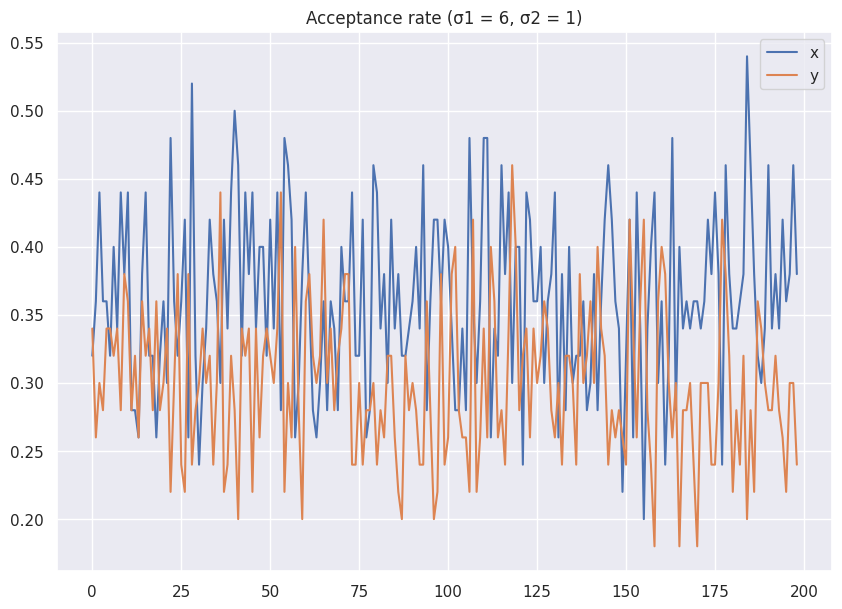

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(acc_x, label='x')
plt.plot(acc_y, label='y')
plt.legend()
plt.title('Acceptance rate (σ1 = 6, σ2 = 1)')
plt.show()


#### 3. Autocorrelation Plots


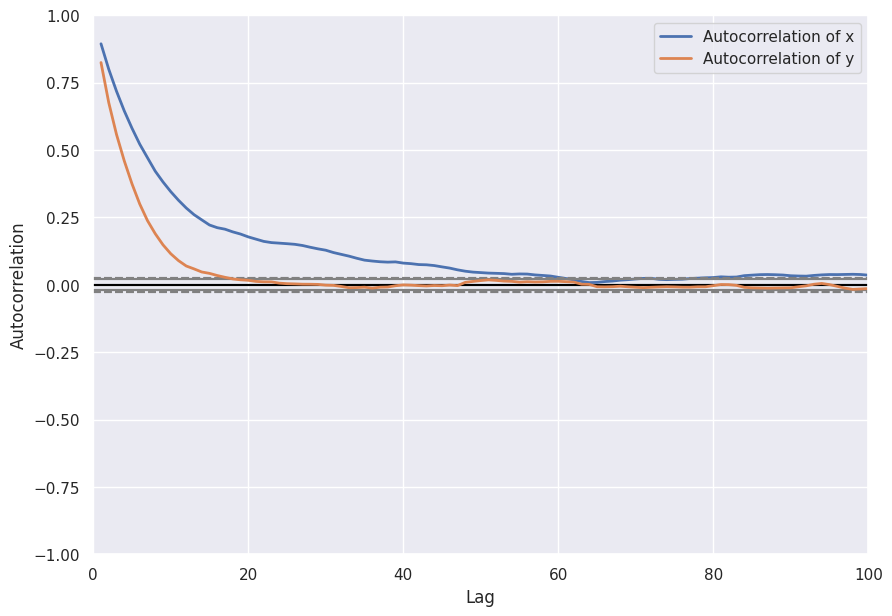

In [14]:
# Creating Autocorrelation plots
plt.figure(figsize=(10, 7))
pd.plotting.autocorrelation_plot(sam[:, 0], label='Autocorrelation of x', linewidth=2)
pd.plotting.autocorrelation_plot(sam[:, 1], label='Autocorrelation of y', linewidth=2)
# Limit the lags in the plot
plt.xlim((0, 100))
plt.show()


#### 4. Interpretation
This method demonstrates the best results. The sampling aligns closely with the target distribution, and the acceptance rates for both x and y-coordinates are nearly equal and optimal. The autocorrelation plots for both coordinates converge quickly, indicating that the sampled points exhibit low correlation and good randomness. This method significantly improves the performance of the algorithm.


1.B – Adaptive Metropolis-Hastings within Gibbs sampler
We proceed as follows:
For each of the variables $ x_i $, we create an associate variable $ \ell_i $ representing the logarithm of the standard deviation $ \sigma_i $ to be used when proposing a normal increment to variable $ x_i $:
$
\ell_i := \log(\sigma_i)
$
We initialize all $ \ell_i $ to zero, which corresponds to the unit proposal variance.

After the $ j $-th ($ j \in \mathbb{N}^* $) batch of 50 iterations, each variable $ \ell_i $ is updated by adding or subtracting an amount $ \delta(j) $. The adaptation attempts to make the acceptance rate of proposals for variable $ x_i $ as close as possible to 0.234, which is optimal for one-dimensional proposals in certain settings. Specifically:

- If the acceptance rate for the $ i $-th variable is greater than 0.234, $ \ell_i $ is increased by $ \delta(j) $.
- Otherwise, if the rate is lower than 0.234, $ \ell_i $ is decreased by $ \delta(j) $.

In practice, we can take $ \delta(j) := \min(0.01, j^{-1/2}) $.

### Question 1:
Implement the adaptive Metropolis-Hastings within Gibbs sampler and test the algorithm on the density $ \pi $ defined in Part A. Using auto-correlation plots (use a built-in function), compare the performance of the algorithm with and without adaptation.


In [2]:
# Adaptive Metropolis-Hastings within Gibbs Sampler
def Ada_MH(x0, y0, p, a, N):
    # Initialize variables
    sam = np.zeros((N, 2))
    sam[0, :] = [x0, y0]
    acc_rate_x = 0
    acc_rate_y = 0
    acc_x = []
    acc_y = []
    l1, l2 = 0, 0
    j = 0

    for i in range(1, N):
        u = np.random.uniform()
        if u <= p:
            # Sample from first conditional
            x, y, val, b = sample_P1(sam[i - 1, 0], sam[i - 1, 1], [np.exp(l1), np.exp(l2)], a)
            sam[i, :] = [x, y]
            if b:
                acc_rate_x += 1
        else:
            # Sample from second conditional
            x, y, val, b = sample_P2(sam[i - 1, 0], sam[i - 1, 1], [np.exp(l1), np.exp(l2)], a)
            sam[i, :] = [x, y]
            if b:
                acc_rate_y += 1

        # Adaptive part every 50 iterations
        if i % 50 == 0:
            j += 1
            if acc_rate_x / 50 > 0.234:
                l1 += min(0.01, 1 / np.sqrt(j))
            else:
                l1 -= min(0.01, 1 / np.sqrt(j))

            if acc_rate_y / 50 > 0.234:
                l2 += min(0.01, 1 / np.sqrt(j))
            else:
                l2 -= min(0.01, 1 / np.sqrt(j))

            acc_x.append(acc_rate_x / 50)
            acc_y.append(acc_rate_y / 50)
            acc_rate_x, acc_rate_y = 0, 0

    return sam, acc_x, acc_y


#### 1. Sampling Results  
We test the Adaptive Metropolis-Hastings algorithm on the given density and plot the sampled points.


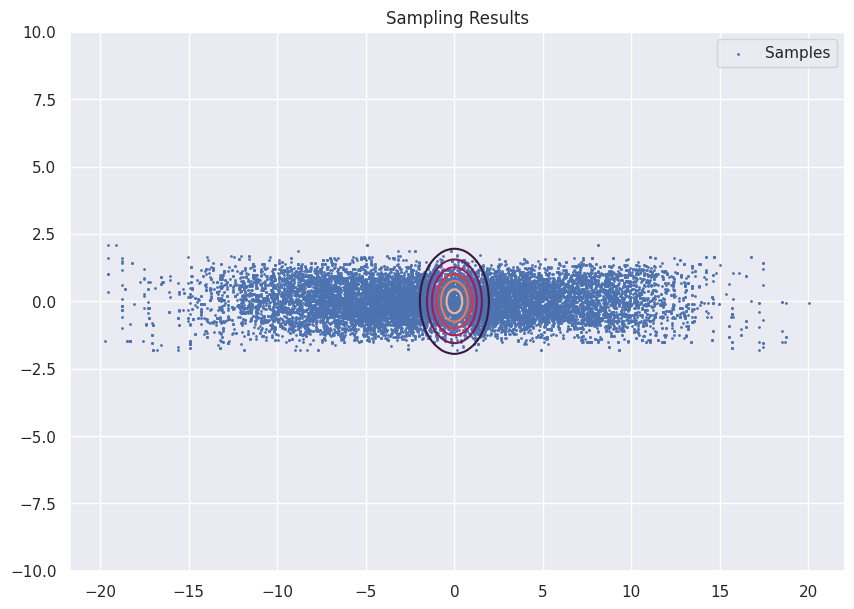

In [15]:
# Test the algorithm
# Assuming sample_P1 and sample_P2 are defined
sam, acc_x, acc_y = Ada_MH(0, 0, 0.5, 10, 20000)

# Plot the sampling result
X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
Z = np.exp(-0.5 * (X**2 + Y**2))  # Example target density

plt.figure(figsize=(10, 7))
plt.contour(X, Y, Z)
plt.scatter(sam[:, 0], sam[:, 1], s=1, label='Samples')
plt.title('Sampling Results')
plt.legend()
plt.show()


#### 2. Acceptance Rate  
We plot the acceptance rate over iterations for both $ x $ and $ y $ coordinates.


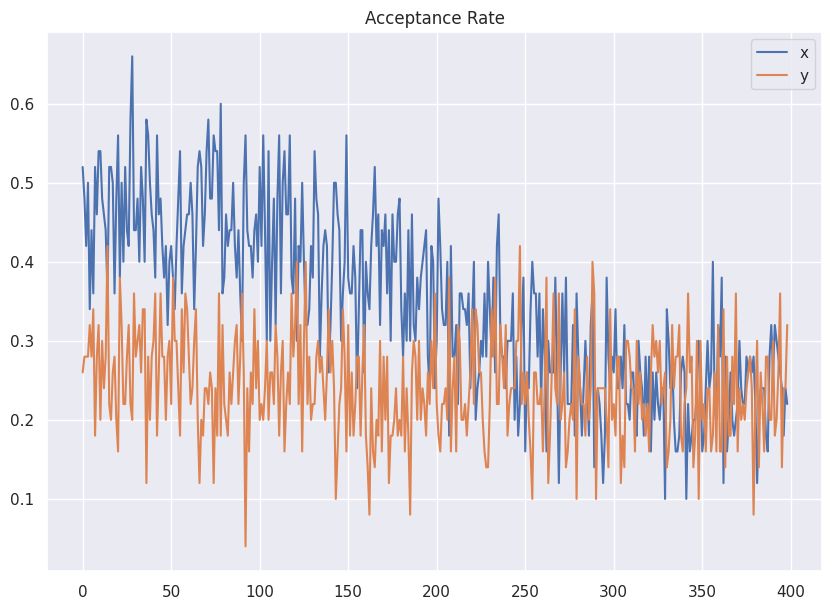

In [16]:
# Plot acceptance rates
plt.figure(figsize=(10, 7))
plt.plot(acc_x, label='x')
plt.plot(acc_y, label='y')
plt.legend()
plt.title('Acceptance Rate')
plt.show()


#### 3. Autocorrelation Plots  
We generate autocorrelation plots for the sampled $ x $ and $ y $ coordinates to evaluate the performance of the algorithm.


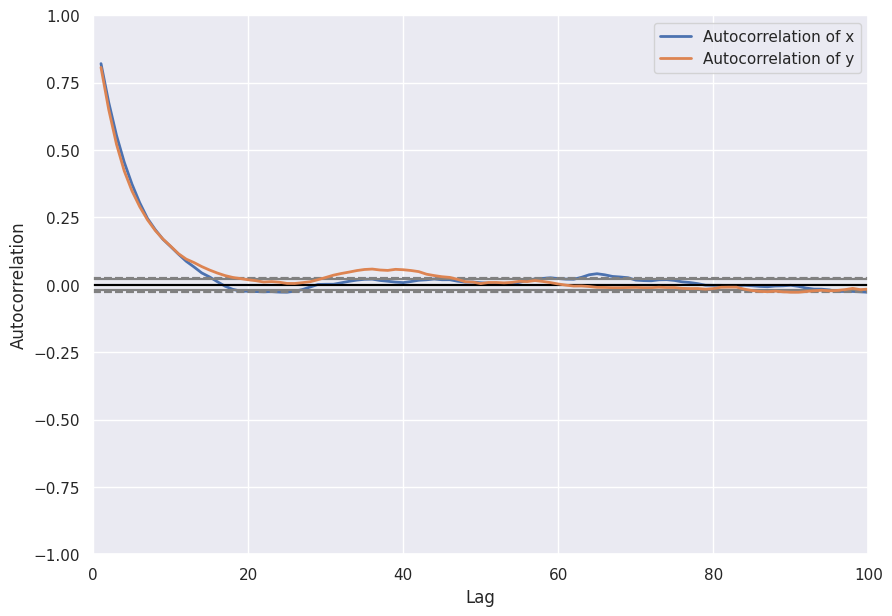

In [18]:
# Create autocorrelation plots
plt.figure(figsize=(10, 7))
pd.plotting.autocorrelation_plot(sam[10000:, 0], label='Autocorrelation of x', linewidth=2)
pd.plotting.autocorrelation_plot(sam[10000:, 1], label='Autocorrelation of y', linewidth=2)
plt.xlim((0, 100))
plt.legend()
plt.show()


#### 5. Interpretation  
We can notice that we are able to sample from the banana-shaped distribution. However, the autocorrelation curves are too high, which means that the data is not random. Nevertheless, we can say that even though the target distribution is much more complicated, this adaptive algorithm is able to sample it and provides good performance.


## Exercise 2: Sampling from Multimodal Distributions

### **2.A – A Toy Example**

#### **Question 1:**
Write a Metropolis-Hastings Symmetric Random Walk algorithm (you may use your code from previous tutorial classes) to sample from $\pi$.


In [19]:
# Define the target distribution
def target_distribution(x, means, variances, weights, n_modes):
    density = 0
    for i in range(n_modes):
        exponent = -np.dot(x - means[i], (x - means[i])) / (2 * variances[i]**2)
        density += weights[i] / (2 * np.pi * variances[i]**2) * np.exp(exponent)
    return density

# Define the Metropolis-Hastings symmetric random walk sampler
def metropolis_hastings(initial, means, variances, weights, n_modes, dim, num_samples):
    samples = np.zeros((num_samples, dim))
    samples[0] = initial

    for i in range(1, num_samples):
        current_sample = samples[i - 1]

        # Propose new sample for x-axis
        x_new = np.random.normal(current_sample[0], 1)
        proposed_x = np.array([x_new, current_sample[1]])

        # Acceptance criterion for x-axis
        alpha_x = min(1, target_distribution(proposed_x, means, variances, weights, n_modes) /
                          target_distribution(current_sample, means, variances, weights, n_modes))
        if np.random.rand() < alpha_x:
            samples[i, 0] = x_new
        else:
            samples[i, 0] = current_sample[0]

        # Propose new sample for y-axis
        y_new = np.random.normal(current_sample[1], 1)
        proposed_y = np.array([samples[i, 0], y_new])

        # Acceptance criterion for y-axis
        alpha_y = min(1, target_distribution(proposed_y, means, variances, weights, n_modes) /
                          target_distribution([samples[i, 0], current_sample[1]], means, variances, weights, n_modes))
        if np.random.rand() < alpha_y:
            samples[i, 1] = y_new
        else:
            samples[i, 1] = current_sample[1]

    return samples


### **2. Sampling Results**


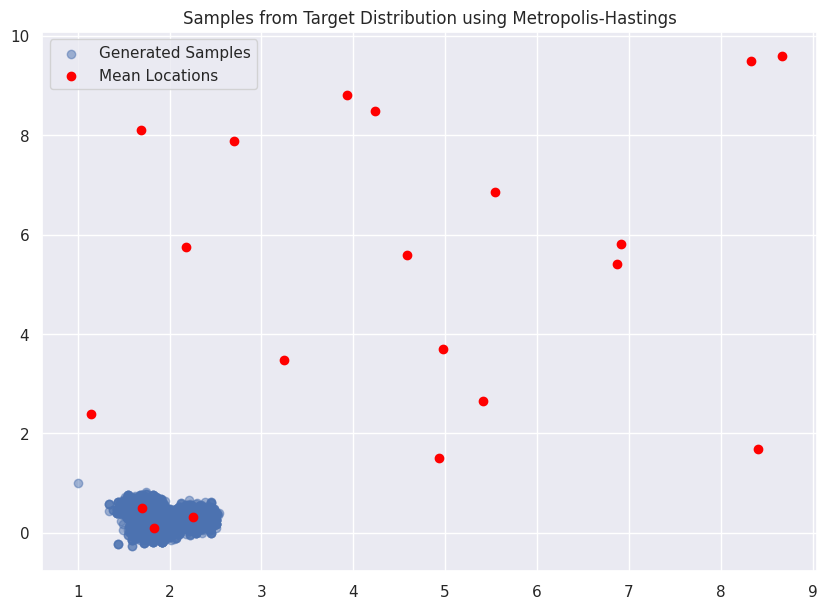

In [20]:
# Parameters
n_modes = 20
dim = 2
variances = np.full(n_modes, 0.1)
weights = np.full(n_modes, 0.05)
initial_point = np.array([1.0, 1.0])
means = np.array([[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82],
                  [3.25, 3.47], [1.70, 0.50], [4.59, 5.60], [6.91, 5.81], [6.87, 5.40],
                  [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50],
                  [4.93, 1.50], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]])

# Generate samples
samples = metropolis_hastings(initial_point, means, variances, weights, n_modes, dim, num_samples=10000)

# Visualization
plt.figure(figsize=(10, 7))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label="Generated Samples")
plt.scatter(means[:, 0], means[:, 1], color='red', label="Mean Locations")
plt.title("Samples from Target Distribution using Metropolis-Hastings")
plt.legend()
plt.show()


### **3. Autocorrelation Plots**


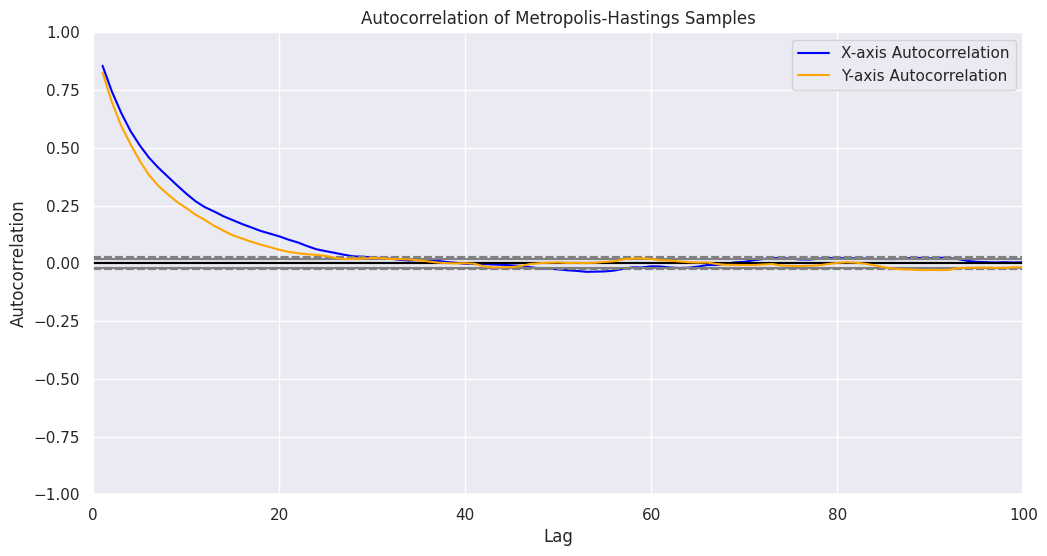

In [21]:
# Autocorrelation plots for each dimension
plt.figure(figsize=(12, 6))
pd.plotting.autocorrelation_plot(samples[:, 0], label="X-axis Autocorrelation", color='blue')
pd.plotting.autocorrelation_plot(samples[:, 1], label="Y-axis Autocorrelation", color='orange')
plt.xlim(0, 100)
plt.legend()
plt.title("Autocorrelation of Metropolis-Hastings Samples")
plt.show()


### **4. Interpretation**

> The Metropolis-Hastings algorithm struggles with this multimodal target distribution. Due to its local proposal mechanism, the sampler remains trapped in a single mode for extended periods, failing to explore the entire space efficiently. The autocorrelation plots reveal significant dependencies between samples, indicative of poor mixing.

> This limitation makes Metropolis-Hastings unsuitable for distributions with widely separated modes. The next step will explore whether the adaptive Metropolis-Hastings algorithm improves the sampling process.


### 2.B – Parallel Tempering
#### **Question 1:**  
Implement the Parallel Tempering algorithm.


In [28]:
# Target distribution
def pi (x,mu,sigma,w,N):

    pii = 0
    for i in range(N):
        pii += w[i]/(2*np.pi*sigma[i]**2) * np.exp(-(x-mu[i,:]).T.dot(x-mu[i,:])/(2*sigma[i]**2))
    return pii

# Parallel Tempering Algorithm
def parallel_tempering(temperatures, iterations, dim, means, variances, weights, num_modes):
    n_chains = len(temperatures)
    samples = np.zeros((n_chains, iterations + 1, dim))  # Samples for each chain
    taus = [0.25 * np.sqrt(temp) for temp in temperatures]  # Step size

    for n in range(iterations):
        # Step 1: Generate proposals for each chain
        for i, temp in enumerate(temperatures):
            # Propose new x-coordinate
            x_new = np.random.normal(samples[i, n, 0], taus[i])
            proposed_x = np.array([x_new, samples[i, n, 1]])

            # Acceptance for x-coordinate
            log_alpha_x = min(0, (np.log(pi(proposed_x, means, variances, weights, num_modes)) / temp)
                              - (np.log(pi(samples[i, n], means, variances, weights, num_modes)) / temp))
            if np.log(np.random.rand()) <= log_alpha_x:
                samples[i, n + 1, 0] = x_new
            else:
                samples[i, n + 1, 0] = samples[i, n, 0]

            # Propose new y-coordinate
            y_new = np.random.normal(samples[i, n, 1], taus[i])
            proposed_y = np.array([samples[i, n + 1, 0], y_new])

            # Acceptance for y-coordinate
            log_alpha_y = min(0, (np.log(pi(proposed_y, means, variances, weights, num_modes)) / temp)
                              - (np.log(pi([samples[i, n + 1, 0], samples[i, n, 1]], means, variances, weights, num_modes)) / temp))
            if np.log(np.random.rand()) <= log_alpha_y:
                samples[i, n + 1, 1] = y_new
            else:
                samples[i, n + 1, 1] = samples[i, n, 1]

        # Step 2: Swap states between adjacent chains
        i = np.random.randint(0, n_chains - 1)  # Select random adjacent chains
        j = i + 1

        alpha_swap = min(1,
                         (pi(samples[j, n + 1], means, variances, weights, num_modes) ** (1 / temperatures[i])
                          * pi(samples[i, n + 1], means, variances, weights, num_modes) ** (1 / temperatures[j]))
                         /
                         (pi(samples[i, n + 1], means, variances, weights, num_modes) ** (1 / temperatures[i])
                          * pi(samples[j, n + 1], means, variances, weights, num_modes) ** (1 / temperatures[j]))
                        )
        if np.random.rand() <= alpha_swap:
            samples[i, n + 1], samples[j, n + 1] = samples[j, n + 1], samples[i, n + 1].copy()

    return samples


#### **Question 2:**  
Illustrate the performance of the algorithm by sampling from the distribution $\pi$ of Part A. Use $K = 5$ with the temperatures ladder:  
$(T_1, T_2, T_3, T_4, T_5) = (60, 21.6, 7.7, 2.8, 1)$  
The proposal distribution is a bivariate Gaussian with variance-covariance matrix $\tau_i^2 I_2$, where $\tau_i = 0.25 \sqrt{T_i}$.


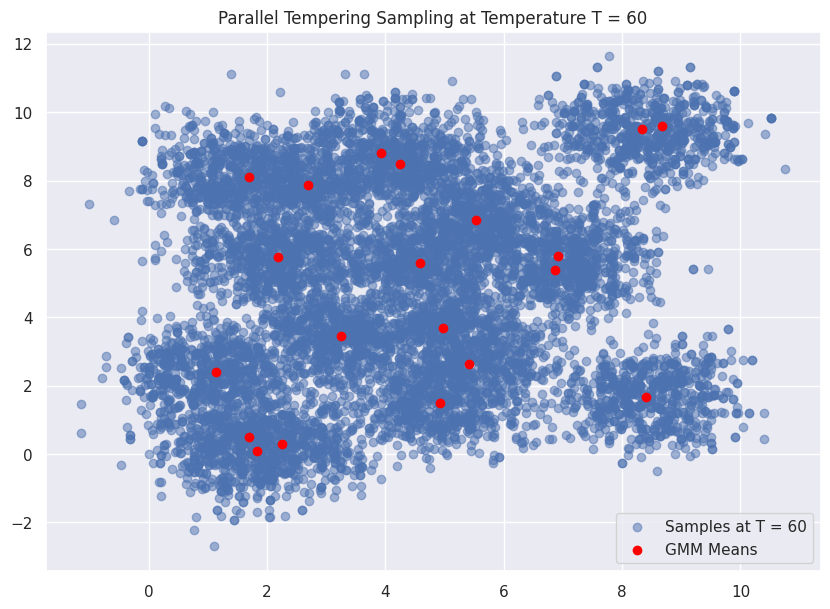

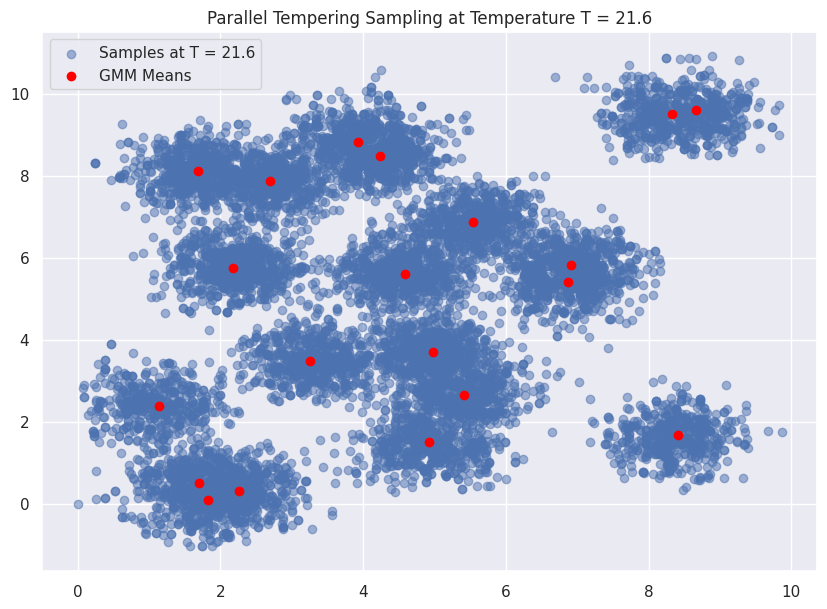

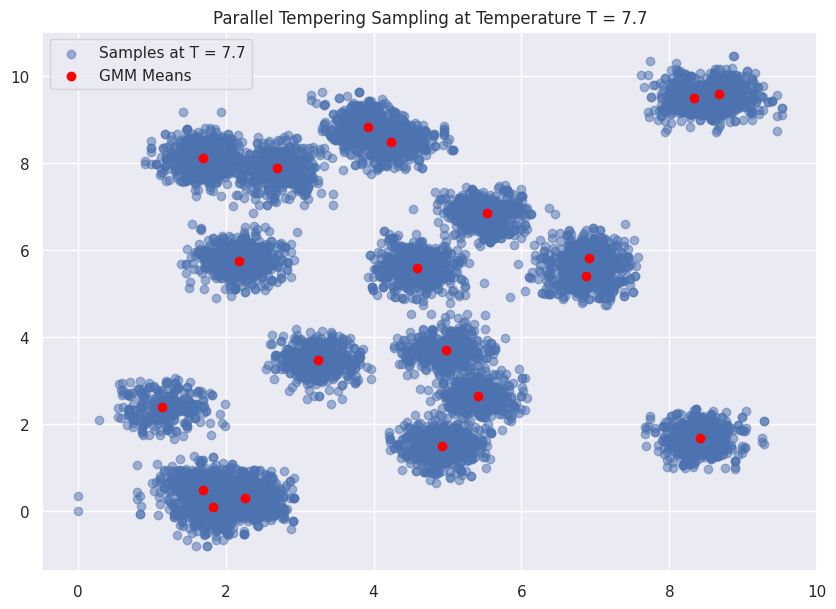

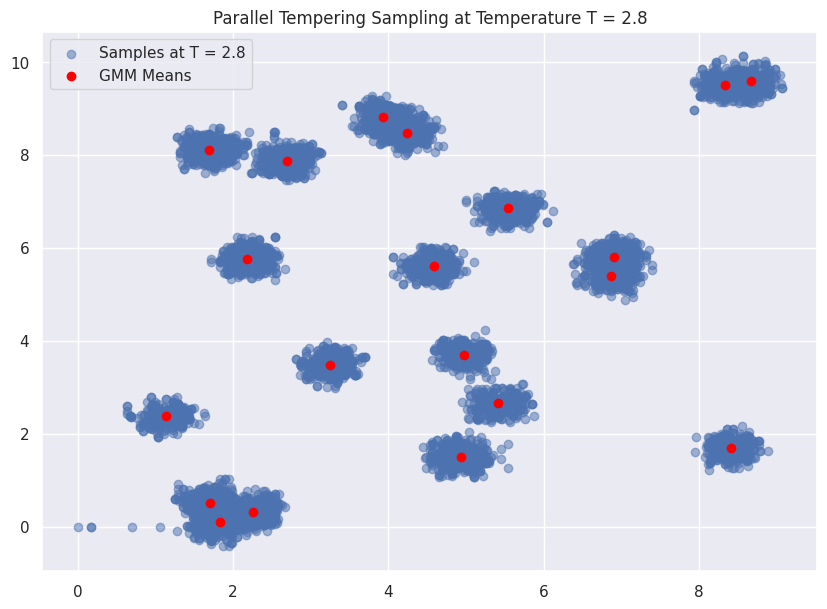

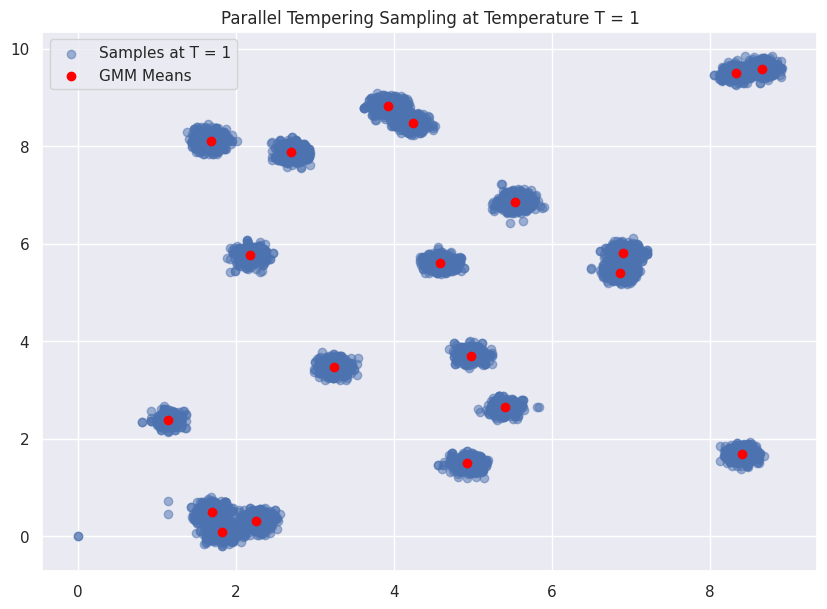

In [29]:
# Parameters
temperatures = [60, 21.6, 7.7, 2.8, 1]
iterations = 10000
dim = 2
num_modes = 20
variances = np.ones(num_modes) * 0.1
weights = np.ones(num_modes) * 0.05
means = np.array([[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82],
                  [3.25, 3.47], [1.70, 0.50], [4.59, 5.60], [6.91, 5.81], [6.87, 5.40],
                  [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50],
                  [4.93, 1.50], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]])

# Run Parallel Tempering
samples = parallel_tempering(temperatures, iterations, dim, means, variances, weights, num_modes)

# Plot results for each temperature
for idx, temp in enumerate(temperatures):
    plt.figure(figsize=(10, 7))
    plt.scatter(samples[idx, :, 0], samples[idx, :, 1], alpha=0.5, label=f"Samples at T = {temp}")
    plt.scatter(means[:, 0], means[:, 1], color='red', label="GMM Means")
    plt.title(f"Parallel Tempering Sampling at Temperature T = {temp}")
    plt.legend()
    plt.show()


### **Interpretation**

> The Parallel Tempering algorithm effectively samples from the multimodal target distribution.  
> Using a temperature ladder, the chains at higher temperatures explore the space rapidly, facilitating swaps with lower-temperature chains.  
> As the temperature decreases, the samples accurately capture the modes. This interaction enables efficient sampling from widely separated modes of the target distribution.


## Exercise 3: Bayesian Analysis of a One-Way Random Effects Model

#### **Question 1:**  
Write the density of the a posteriori distribution $(X, \mu, \sigma^2, \tau^2)$ — it can be given up to a normalizing constant — i.e., the density of the distribution $(Y, X, \mu, \sigma^2, \tau^2)$.

**Posterior Distribution:**  

The posterior distribution is derived as:  

$$
P(X, \mu, \sigma^2, \tau^2 | Y) \propto P(Y | X, \tau^2) \cdot P(X | \mu, \sigma^2) \cdot P(\mu, \sigma^2, \tau^2)
$$  

- $P(Y | X, \tau^2) \propto (\tau^2)^{-\frac{nk}{2}} \exp \left( -\frac{\sum_{i=1}^n \sum_{j=1}^{k_i} (y_{ij} - X_i)^2}{2\tau^2} \right)$  
- $P(X | \mu, \sigma^2) \propto (\sigma^2)^{-\frac{n}{2}} \exp \left( -\frac{\sum_{i=1}^n (X_i - \mu)^2}{2\sigma^2} \right)$  
- $P(\mu, \sigma^2, \tau^2) \propto (\sigma^2)^{-(1+\alpha)} \exp \left( -\frac{\beta}{\sigma^2} \right) \cdot (\tau^2)^{-(1+\gamma)} \exp \left( -\frac{\beta}{\tau^2} \right)$  

Bringing it together:  

$$
P(X, \mu, \sigma^2, \tau^2 | Y) \propto (\tau^2)^{-\frac{nk}{2} - (1 + \gamma)} (\sigma^2)^{-\frac{n}{2} - (1 + \alpha)}
\exp \left( -\frac{\sum_{i=1}^n \sum_{j=1}^{k_i} (y_{ij} - X_i)^2}{2\tau^2} - \frac{\sum_{i=1}^n (X_i - \mu)^2}{2\sigma^2} - \frac{\beta}{\sigma^2} - \frac{\beta}{\tau^2} \right)
$$

#### **Question 2:**  
Implement a Gibbs sampler that updates $(\sigma^2, \tau^2, \mu, X)$ one at a time.  


In [30]:
# Gibbs Sampler Implementation
def gibbs_sampler(observations, sigma2_init, tau2_init, mu_init, X_init, beta, alpha, gamma, n_groups, obs_per_group, iterations):
    # Initialize variables
    sigma2_chain, tau2_chain, mu_chain, X_chain = [], [], [], []
    sigma2, tau2, mu, X = sigma2_init, tau2_init, mu_init, X_init

    for _ in range(iterations):
        # Update sigma^2
        shape = n_groups / 2 + alpha
        scale = 1 / (beta + np.sum((X - mu)**2) / 2)
        sigma2 = 1 / np.random.gamma(shape, scale)

        # Update tau^2
        shape = (n_groups * obs_per_group) / 2 + gamma
        scale = 1 / (beta + np.sum((observations - X[:, None])**2) / 2)
        tau2 = 1 / np.random.gamma(shape, scale)

        # Update mu
        mu_mean = np.mean(X)
        mu_variance = sigma2 / n_groups
        mu = np.random.normal(mu_mean, np.sqrt(mu_variance))

        # Update X
        for i in range(n_groups):
            var = (tau2 * sigma2) / (obs_per_group * sigma2 + tau2)
            mean = var * (np.sum(observations[i]) / tau2 + mu / sigma2)
            X[i] = np.random.normal(mean, np.sqrt(var))

        # Store the samples
        sigma2_chain.append(sigma2)
        tau2_chain.append(tau2)
        mu_chain.append(mu)
        X_chain.append(X.copy())

    return sigma2_chain, tau2_chain, mu_chain, X_chain


#### **Question 3:**  
Implement a Block-Gibbs sampler that updates $\sigma^2$, $\tau^2$, and then $(X, \mu)$ together as a block.


In [31]:
# Block-Gibbs Sampler Implementation
def block_gibbs_sampler(observations, sigma2_init, tau2_init, mu_init, X_init, beta, alpha, gamma, n_groups, obs_per_group, iterations):
    # Initialize variables
    sigma2_chain, tau2_chain, mu_chain, X_chain = [], [], [], []
    sigma2, tau2, mu, X = sigma2_init, tau2_init, mu_init, X_init

    for _ in range(iterations):
        # Update sigma^2
        shape = n_groups / 2 + alpha
        scale = 1 / (beta + np.sum((X - mu)**2) / 2)
        sigma2 = 1 / np.random.gamma(shape, scale)

        # Update tau^2
        shape = (n_groups * obs_per_group) / 2 + gamma
        scale = 1 / (beta + np.sum((observations - X[:, None])**2) / 2)
        tau2 = 1 / np.random.gamma(shape, scale)

        # Update (X, mu) jointly
        precision_matrix = np.zeros((n_groups + 1, n_groups + 1))
        y_sum = np.sum(observations, axis=1)
        y_vector = np.append(y_sum / tau2, [0])  # Add dummy row for mu

        for i in range(n_groups):
            precision_matrix[i, i] = (obs_per_group / tau2) + (1 / sigma2)
            precision_matrix[i, -1] = -1 / sigma2
            precision_matrix[-1, i] = -1 / sigma2
        precision_matrix[-1, -1] = n_groups / sigma2

        cov_matrix = np.linalg.inv(precision_matrix)
        mean_vector = np.dot(cov_matrix, y_vector)
        joint_sample = np.random.multivariate_normal(mean_vector, cov_matrix)

        X = joint_sample[:-1]
        mu = joint_sample[-1]

        # Store the samples
        sigma2_chain.append(sigma2)
        tau2_chain.append(tau2)
        mu_chain.append(mu)
        X_chain.append(X.copy())

    return sigma2_chain, tau2_chain, mu_chain, X_chain


#### **Question 4:**  
Discuss the theoretical performance of these two algorithms.

> The Gibbs sampler updates one variable at a time, which can lead to slower mixing and convergence, especially in high-dimensional parameter spaces.  
> The Block-Gibbs sampler, by jointly sampling $(X, \mu)$, improves convergence by reducing the dependency between successive samples. It achieves faster mixing compared to the standard Gibbs sampler.  
> However, the Block-Gibbs sampler involves matrix computations (e.g., inversion), which may become computationally expensive as the number of groups increases.  


#### **Question 5:**  
Test your code on a synthetic dataset $Y = \{ y_{i,j} , i \in J1,NK, j \in J1, k_iK \}$.


In [32]:
# Synthetic Data Generation
np.random.seed(42)
N = 100  # Number of groups
k = 50   # Observations per group

# True parameters
true_mu = 3
true_sigma2 = 1
true_tau2 = 0.5

# Generate observations
X_true = np.random.normal(true_mu, np.sqrt(true_sigma2), size=N)
Y = np.array([np.random.normal(Xi, np.sqrt(true_tau2), size=k) for Xi in X_true])

# Initial guesses
sigma2_init, tau2_init, mu_init = 2, 1, 0
X_init = np.zeros(N)
alpha, beta, gamma = 0.1, 0.1, 0.1
iterations = 1000


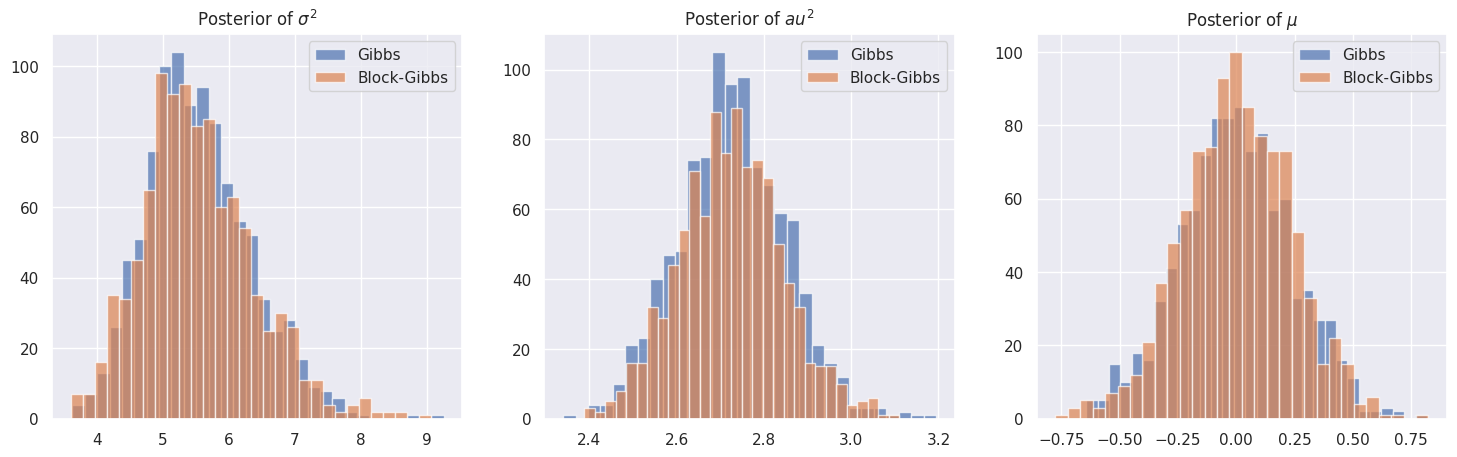

In [53]:
# Gibbs Sampler Testing
sigma2_samples, tau2_samples, mu_samples, X_samples = gibbs_sampler(Y, sigma2_init, tau2_init, mu_init, X_init, beta, alpha, gamma, N, k, iterations)

# Block-Gibbs Sampler Testing
block_sigma2_samples, block_tau2_samples, block_mu_samples, block_X_samples = block_gibbs_sampler(Y, sigma2_init, tau2_init, mu_init, X_init, beta, alpha, gamma, N, k, iterations)

# Plot Results
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.hist(sigma2_samples, bins=30, alpha=0.7, label="Gibbs")
plt.hist(block_sigma2_samples, bins=30, alpha=0.7, label="Block-Gibbs")
plt.title("Posterior of $\sigma^2$")
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(tau2_samples, bins=30, alpha=0.7, label="Gibbs")
plt.hist(block_tau2_samples, bins=30, alpha=0.7, label="Block-Gibbs")
plt.title("Posterior of ${\tau}^2$")
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(mu_samples, bins=30, alpha=0.7, label="Gibbs")
plt.hist(block_mu_samples, bins=30, alpha=0.7, label="Block-Gibbs")
plt.title("Posterior of $\mu$")
plt.legend()

plt.show()


#### **Interpretation**

> Both the Gibbs and Block-Gibbs samplers estimate the parameters $\sigma^2$, $\tau^2$, and $\mu$ reasonably well.  
> However, the Block-Gibbs sampler exhibits better mixing and less correlation between successive samples, as evident from the histograms.  
> In scenarios with a large number of groups or observations, Block-Gibbs sampling is computationally advantageous, offering faster convergence and better exploration of the posterior.
